<a href="https://colab.research.google.com/github/SquirrelLover/FearNet-Implementation/blob/main/mPFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision
import torchvision.transforms as transforms

In [4]:
Mini_batch = 450
Dropout = 0.25
Learning_Rate = 2e-3

Files already downloaded and verified
Files already downloaded and verified
Train Loader Images:


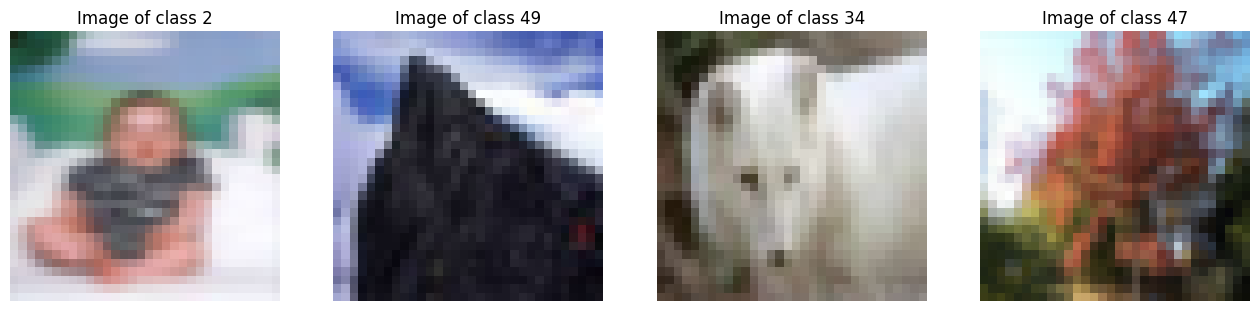

In [5]:
# Load Dataset (CIFAR-100)

transform = transforms.Compose([
    transforms.ToTensor(),
    # insert more transformations of data i.e. normalization
])

train_data = torchvision.datasets.CIFAR100(root='./data', train=True, transform = transform, download = True)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, transform = transform, download = True)

train_loader = DataLoader(train_data, batch_size = Mini_batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size = Mini_batch, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# view a couple of sample images to make sure they are loaded

print("Train Loader Images:")
images, labels = next(iter(train_loader))
images = images.cpu().detach().numpy()
plt.figure(figsize=(16, 4))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(np.transpose(images[i], (1, 2, 0)))
  plt.axis('off')
  plt.title(f"Image of class {labels[i].item()}")
plt.show()

In [13]:
# define mPFC (long term)

class mPFC(nn.Module):
  def __init__(self, input_dim=3072, autoencoder_hidden_dims = np.array([256]), classifier_dims = np.array([961, 525, 289, 100]), lambda_values=None, learning_rate=Learning_Rate):
    super(mPFC, self).__init__()
    # encoder
    encoder_layers = []
    current_dim = input_dim
    for hidden_dim in autoencoder_hidden_dims:
      print(hidden_dim)
      encoder_layers.append(nn.Linear(current_dim, hidden_dim))
      encoder_layers.append(nn.ELU())
      current_dim = hidden_dim
    self.encoder = nn.Sequential(*encoder_layers)

    # decoder
    decoder_layers = []
    hidden_dims_reversed = list(autoencoder_hidden_dims[::-1])
    for hidden_dim in hidden_dims_reversed:
      decoder_layers.append(nn.Linear(current_dim, hidden_dim))
      decoder_layers.append(nn.ELU())
      current_dim = hidden_dim
    decoder_layers.append(nn.Linear(current_dim, input_dim))
    decoder_layers.append(nn.ELU())
    self.decoder = nn.Sequential(*decoder_layers)

    #classifier
    current_dim = autoencoder_hidden_dims[-1]
    classifier_layers= []

    if len(classifier_dims) != 1:
      classifier_layers.append(nn.Linear(current_dim, classifier_dims[0]))
      classifier_layers.append(nn.ELU())
      #classifier_layers.append(nn.Dropout(p=Dropout))
      current_dim = classifier_dims[0]

      for i in range(1, len(classifier_dims)-1):
        hidden_dim = classifier_dims[i]
        classifier_layers.append(nn.Linear(current_dim, hidden_dim))
        classifier_layers.append(nn.ELU())
        #classifier_layers.append(nn.Dropout(p=Dropout))
        current_dim = hidden_dim

    classifier_layers.append(nn.Linear(current_dim, classifier_dims[len(classifier_dims)-1]))

    self.classifier = nn.Sequential(*classifier_layers)

    # lambda
    self.lambda_values = torch.tensor(lambda_values if lambda_values else [1.0] * len(autoencoder_hidden_dims), dtype=torch.float32)

    # optimizer
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

  def encoder_forward(self, x):
    encoder_intermediates = [x]
    for layer in self.encoder:
      x = layer(x)
      encoder_intermediates.append(x)
    encoded = encoder_intermediates[-1]
    return encoded, encoder_intermediates

  def decoder_forward(self, x):
    decoder_intermediates = [x]
    for layer in self.decoder:
      x = layer(x)
      decoder_intermediates.append(x)
    pseudo_img = decoder_intermediates[-1]
    return pseudo_img, list(decoder_intermediates[::-1])

  def classify(self, x):
    class_logits = self.classifier(x)
    return class_logits

  def compute_loss(self, class_logits, targets, encoder_intermediates, decoder_intermediates):
    # classification loss
    classification_loss = nn.CrossEntropyLoss()(class_logits, targets)

    # reconstruction loss with lambda weighting
    reconstruction_loss = 0
    for i in range(len(self.lambda_values)):
      encoder_hidden = encoder_intermediates[i]
      decoder_hidden = decoder_intermediates[i]
      diff = encoder_hidden - decoder_hidden
      squared_diff = diff.pow(2)
      layer_loss = squared_diff.sum()
      reconstruction_loss += self.lambda_values[i] * layer_loss

    # total loss
    total_loss = classification_loss + reconstruction_loss

    return classification_loss, reconstruction_loss, total_loss

  def training_step(self, data_loader, device):
    self.train()

    total_classification_loss = 0
    total_reconstruction_loss = 0
    total_total_loss = 0

    for x, targets in data_loader:
      x, targets = x.to(device), targets.to(device)

      # forward pass
      encoded, encoder_intermediates = self.encoder_forward(x)
      pseudo_img, decoder_intermediates = self.decoder_forward(encoded)
      class_logits = self.classify(encoded)

      # compute losses
      classification_loss, reconstruction_loss, total_loss = self.compute_loss(
        class_logits, targets, encoder_intermediates, decoder_intermediates
      )

      # zero gradients
      self.optimizer.zero_grad()
      for param in self.decoder.parameters():
        param.grad = None
      for param in self.encoder.parameters():
        param.grad = None

      # backward pass
      classification_loss.backward(retain_graph=True)
      classifier_grads = {name: param.grad.clone() for name, param in self.classifier.named_parameters()}
      reconstruction_loss.backward(retain_graph=True)
      decoder_grads = {name: param.grad.clone() for name, param in self.decoder.named_parameters()}
      total_loss.backward()
      for name, param in self.encoder.named_parameters():
        if param.grad is not None:
          param.grad.data = param.grad.data

      # optimizer
      encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=self.optimizer.defaults['lr'])
      encoder_optimizer.step()
      classifier_optimizer = optim.Adam(self.classifier.parameters(), lr=self.optimizer.defaults['lr'])
      classifier_optimizer.step()
      decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=self.optimizer.defaults['lr'])
      decoder_optimizer.step()

      # update parameters
      for name, param in self.classifier.named_parameters():
        if param.grad is not None:
          param.grad.data = classifier_grads[name].data
      for name, param in self.decoder.named_parameters():
        if param.grad is not None:
          param.grad.data = decoder_grads[name].data

      # add losses to total
      total_classification_loss += classification_loss.item()
      total_reconstruction_loss += reconstruction_loss.item()
      total_total_loss += total_loss.item()

    # average loss
    average_classification_loss = total_classification_loss / len(data_loader)
    average_reconstruction_loss = total_reconstruction_loss / len(data_loader)
    average_total_loss = total_total_loss / len(data_loader)

    return average_classification_loss, average_reconstruction_loss, average_total_loss

  def generate_statistics(self, list_feature_vectors, device):
    self.eval()

    latent_rep = []

    with torch.no_grad():
      for x, targets in list_feature_vectors:
        x, targets = x.to(device), targets.to(device)

        # pass through encoder
        mPFC_out, _ = self.encoder_forward(x)
        latent_rep.append(mPFC_out.cpu())

    # stack
    latent_rep = torch.cat(latent_rep, dim=0)

    # ux
    ux_mPFC = latent_rep.mean(dim=0)

    # covariance matrix
    centered_mPFC_features = latent_rep - ux_mPFC
    covariance_matrix_mPFC = torch.matmul(centered_mPFC_features.t(), centered_mPFC_features) / (latent_rep.size(0) - 1)

    return ux_mPFC, covariance_matrix_mPFC

  def pseudoimg_from_statistics(self, u, covar, count):
    self.eval()

    # sampling from a multivariate normal distribution
    distribution = torch.distributions.MultivariateNormal(u, covar)
    sampled_vectors = distribution.sample((count,)).to(device)

    # pass through decoder
    pseudo_images = []
    with torch.no_grad():
      for latent_vector in sampled_vectors:
        pseudo_img, _ = self.decoder_forward(latent_vector)
        pseudo_images.append(pseudo_img.cpu())

    # stack
    pseudo_images = torch.stack(pseudo_images, dim=0)

    return pseudo_images

  def calculate_accuracy(self, data_loader, device):
    self.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for x, targets in data_loader:
        x, targets = x.to(device), targets.to(device)
        encoded, _ = self.encoder_forward(x)
        class_logits = self.classify(encoded)
        _, predicted = torch.max(class_logits.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [15]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

model = mPFC(learning_rate=1e-3)
model = model.to(device)

feature_vectors = torch.flatten(torch.from_numpy(images), start_dim=1)
dataset = FeatureDataset(feature_vectors, labels)
data_loader = DataLoader(dataset, batch_size=Mini_batch, shuffle=True)

for epoch in range(100):
    data_loader = DataLoader(dataset, batch_size=Mini_batch, shuffle=True)

    avg_classification_loss, avg_reconstruction_loss, avg_total_loss = model.training_step(data_loader, device)

    print(f"Epoch {epoch+1}, Total Loss: {avg_total_loss}, Classification Loss: {avg_classification_loss}, Reconstruction Loss: {avg_reconstruction_loss}")
    for param_group in model.optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name} gradient norm: {param.grad.norm().item()}")

    accuracy = model.calculate_accuracy(data_loader, device)
    print(f"Epoch {epoch+1}, Accuracy: {accuracy}%")

256
Epoch 1, Total Loss: 434501.84375, Classification Loss: 4.603724479675293, Reconstruction Loss: 434497.25
Learning rate: 0.001
encoder.0.weight gradient norm: 405622.71875
encoder.0.bias gradient norm: 14109.0029296875
decoder.0.weight gradient norm: 64699.3984375
decoder.0.bias gradient norm: 14289.9345703125
decoder.2.weight gradient norm: 60413.3125
decoder.2.bias gradient norm: 23314.29296875
classifier.0.weight gradient norm: 0.042778130620718
classifier.0.bias gradient norm: 0.008290215395390987
classifier.2.weight gradient norm: 0.0852585881948471
classifier.2.bias gradient norm: 0.015290752984583378
classifier.4.weight gradient norm: 0.06135959178209305
classifier.4.bias gradient norm: 0.026706796139478683
classifier.6.weight gradient norm: 0.0468364916741848
classifier.6.bias gradient norm: 0.04707425832748413
Epoch 1, Accuracy: 0.2222222222222222%
Epoch 2, Total Loss: 490430.03125, Classification Loss: 4.610817909240723, Reconstruction Loss: 490425.40625
Learning rate: 0.